# Getting Started

The basis of all of our analysis starts with the binaural signal, so we begin by importing the `Binaural` class. We'll also load up and examine our analysis settings.

In [3]:
# imports
from soundscapy import Binaural
from soundscapy import AnalysisSettings
from soundscapy.analysis.binaural import prep_multiindex_df, add_results, process_all_metrics
import json
from pathlib import Path

Set up where the data is located. In this case, we'll use the sample recordings located under the `test` folder.

In [4]:
# May need to adjust for your system
wav_folder = Path().cwd().joinpath("data")

Ensuring that Soundscapy knows exactly how loud your recordings were onsite is crucial to getting correct answers. If you used equipment such as the Head Acoustics SqoBold, and were careful about how the recordings are exported to .wav, then they may already be correctly adjusted (as ours are here). However its best to be safe and calibrate each signal to their real-world dB level. To do this, we load in a .json that contains the per-channel correct dB $L_{eq}$ level.

In [5]:
levels = wav_folder.joinpath("Levels.json")

with open("data/Levels.json") as f:
    levels= json.load(f)

# Look at the first five sets of levels
list(levels.items())[:5]
#or
#list(levels.items())

[('CT101', {'Left': 79.0, 'Right': 79.72}),
 ('CT102', {'Left': 79.35, 'Right': 79.88}),
 ('CT103', {'Left': 76.25, 'Right': 76.41}),
 ('CT104', {'Left': 79.9, 'Right': 79.93}),
 ('CT107', {'Left': 78.21, 'Right': 78.47})]


## Prepping the results dataframe
The easiest way to organise and add the new data as it is processed is to prepare a dataframe ahead of time. We've provided a small function to convert a dictionary of calibration levels (`level`) into the properly formatted dataframe.

In [6]:
df = prep_multiindex_df(levels, incl_metric=True)
df.head()

Leq
Recording Channel       
CT101     Left     79.00
          Right    79.72
CT102     Left     79.35
          Right    79.88
CT103     Left     76.25

## Load in a Binaural recording
Load in a binaural wav signal. We can use the `plot` function provided by the `acoustics.Signal` super-class.

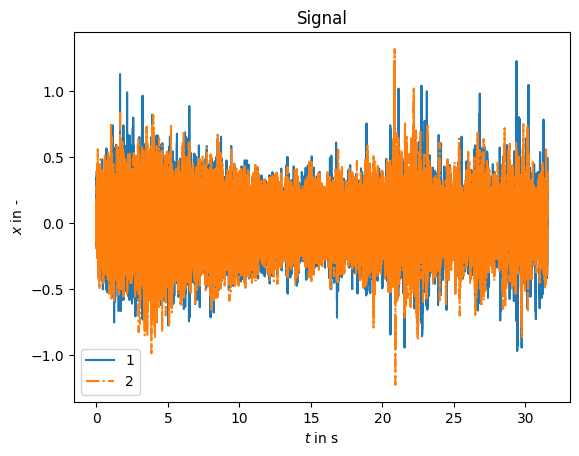

In [6]:
binaural_wav = wav_folder.joinpath("CT109.wav")
b = Binaural.from_wav(binaural_wav)
b.plot();

To ensure that the dB level is correct, and therefore any other metrics are correct, we start by calibrating the signal to precalculated levels.

In [7]:
decibel = (levels[b.recording]["Left"], levels[b.recording]["Right"])
print(f"Calibration levels: {decibel}")
b.calibrate_to(decibel, inplace=True)

Calibration levels: (79.32, 79.37)


Signal([[-0.01880362 -0.02602271 -0.03045224 ...  0.15379328  0.14773124
   0.14079955]
 [ 0.06067053  0.05229311  0.04568887 ...  0.388947    0.38627496
   0.38574696]])

Now, check it by comparing it to what we already knew were the correct levels:

In [8]:
print(f"Predefined levels: {levels[b.recording]}")
print(f"Calculated Levels: {b.pyacoustics_metric('Leq', statistics=['avg'], as_df=False)}")

Predefined levels: {'Left': 79.32, 'Right': 79.37}
Calculated Levels: {'Left': {'Leq': 79.3242384086412}, 'Right': {'Leq': 79.37405170192133}}



# Calculating Acoustic Metrics

This brings us to how to calculate any of the many metrics available. Let's start simple with $L_{Aeq}$.

###  `1) Python Acoustics`

Since the $L_{Aeq}$ calc is provided by the Python Acoustics library, we'll be calling `pyacoustic_metric`. Then, we need to tell it what particular metric we want, what stats to calculate as well, what to label it, and what format to return the results in.

In [9]:
metric = "LAeq"
stats = ("avg", 10, 50, 90, 95, "max")
label = "LAeq"
b.pyacoustics_metric(metric, stats, label, as_df=False)

{'Left': {'LAeq': 69.62980216939728,
  'LAeq_10': 72.53594851528133,
  'LAeq_50': 68.08841267689249,
  'LAeq_90': 65.39585514607839,
  'LAeq_95': 64.84120054285495,
  'LAeq_max': 77.36959269509246},
 'Right': {'LAeq': 68.14073677615188,
  'LAeq_10': 70.78859019475205,
  'LAeq_50': 67.17655974434444,
  'LAeq_90': 64.90071903960418,
  'LAeq_95': 64.3945997426436,
  'LAeq_max': 74.25197080719757}}

If we want, we can get the results back as a pandas DataFrame instead:

In [23]:
b.pyacoustics_metric(metric, stats, label, as_df=True)

LAeq    LAeq_10    LAeq_50    LAeq_90    LAeq_95  \
Recording Channel                                                          
CT109     Left     69.629802  72.535949  68.088413  65.395855  64.841201   
          Right    68.140737  70.788590  67.176560  64.900719  64.394600   

                    LAeq_max  
Recording Channel             
CT109     Left     77.369593  
          Right    74.251971

And we can easily do the same for the C-weighting level, Z-weighting level & SEL:

In [21]:
b.pyacoustics_metric("LCeq", stats, as_df=True)

LCeq    LCeq_10    LCeq_50    LCeq_90    LCeq_95  \
Recording Channel                                                          
CT109     Left     76.587685  79.185724  75.735159  73.091477  72.774754   
          Right    76.188390  78.516271  75.701466  73.030778  72.530938   

                    LCeq_max  
Recording Channel             
CT109     Left     81.623024  
          Right    80.785447

In [26]:
b.pyacoustics_metric("LZeq", stats, as_df=True)

LZeq    LZeq_10    LZeq_50    LZeq_90    LZeq_95  \
Recording Channel                                                          
CT109     Left     79.324238  81.353490  78.172377  75.419130  74.772194   
          Right    79.374052  81.904793  78.125463  75.412322  74.806446   

                    LZeq_max  
Recording Channel             
CT109     Left     87.503510  
          Right    87.849619

In [29]:
b.pyacoustics_metric("SEL", stats, as_df=True)

SEL
Recording Channel                   
CT109     Left     94.31156932047669
          Right    94.36138327962352

By default, the metrics will be calculated for both channels. But you may want only a single channel. This can be set with the `channel` option.

In [ ]:
b.pyacoustics_metric("LZeq", channel="Left")


###  `2) MoSQITo`

MoSQITo is very exciting as it is one of the first completely free and open-source libraries for calculating psychoacoustic features. Let's try out calculating the psychoacoustic loudness.

We start by defining many of the same options, but with two new ones. The first is our `func_args` to pass to `MoSQITo`. Since our test recording was collected in a public park, we need to select the correct field type: free or diffuse, and pass that to MoSQITo.

The second new argument is `parallel`. This just tells Soundscapy whether to try to calculate the Left and Right channels simultaneously to speed up processing.

In [10]:
metric = "loudness_zwtv"
stats = (5, 50, 'avg', 'max')
func_args = {
    'field_type': 'free'
}

b.mosqito_metric(metric, statistics=stats, as_df=True, parallel=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metric: loudness_zwtv


N_5       N_50      N_avg      N_max
Recording Channel                                            
CT109     Left     30.004616  22.080164  23.019382  38.002373
          Right    26.587467  21.040280  21.592433  29.695260

`sharpness_din_from_loudness` is a bit of a special case to keep in mind. It can drastically speed up the processing time since it calculates the Sharpness values from pre-calculated Loudness results. If you are planning to do both analyses, I highly suggest using it. Soundscapy will handle it behind the scenes to make sure it doesn't accidentally calculate the Loudness values twice if you've asked for both of them. Let's try it out.

In [18]:
b.mosqito_metric("sharpness_din_from_loudness", stats, as_df=True, parallel=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metrics: `sharpness_din` from `loudness_zwtv`



###  `3) scikit-maad`


In [13]:
b.maad_metric("all_spectral_alpha_indices", verbose=True)

 - Calculating scikit-maad all_spectral_alpha_indices


MEANf      VARf     SKEWf       KURTf  NBPEAKS  \
Recording Channel                                                      
CT109     Left     0.001629  0.000042  8.588911   95.062840       10   
          Right    0.001481  0.000039  9.446190  111.591921        9   

                        LEQf       ENRf       BGNf      SNRf        Hf  ...  \
Recording Channel                                                       ...   
CT109     Left     76.568509 -16.431491 -19.333055  2.901564  0.383433  ...   
          Right    76.275210 -16.724790 -19.333482  2.608692  0.352009  ...   

                      TFSD  H_Havrda   H_Renyi  H_pairedShannon      H_gamma  \
Recording Channel                                                              
CT109     Left     0.19407  0.316275  1.486264         3.292027  1341.922758   
          Right    0.18078  0.310974  1.350959         3.076537  1161.507510   

                   H_GiniSimpson      RAOQ       AGI  ROItotal  ROIcover  
Recording Channel                                                         
CT109     Left          0.820586  0.013846  1.545552        21  1.545712  
          Right         0.788654  0.014172  1.580759        43  2.021005  

[2 rows x 44 columns]

In [14]:
b.maad_metric("all_temporal_alpha_indices", verbose=True)

 - Calculating scikit-maad all_temporal_alpha_indices


ZCR     MEANt      VARt     SKEWt     KURTt  \
Recording Channel                                                       
CT109     Left     856.658068  0.000219  0.034236  0.068320  4.560748   
          Right    721.710081  0.000092  0.034631  0.041858  4.514463   

                        LEQt      BGNt      SNRt       MED        Ht  \
Recording Channel                                                      
CT109     Left     78.345766 -9.716321  1.222237  0.326726  0.965416   
          Right    78.426752 -9.852782  1.093480  0.321633  0.965988   

                   ACTtFraction  ACTtCount  ACTtMean  EVNtFraction  EVNtMean  \
Recording Channel                                                              
CT109     Left          0.17659        522  5.063980      0.130244  0.038380   
          Right         0.16272        481  4.985885      0.107916  0.032406   

                   EVNtCount  
Recording Channel             
CT109     Left      3.394670  
          Right     3.331218

# Defining Analysis Settings

Soundscapy provides the ability to predefine your analysis settings. These are defined in a separate `.yaml` file and are managed by Soundscapy using the `AnalysisSettings` class. These settings can then be passed to any of the analysis functions, rather than separately defining your settings as we did above. This will be particularly useful when performing our batch processing on an entire folder of wav recordings later.

Soundscapy provides a set of default settings which can be easily loaded in:

In [11]:
analysis_settings = AnalysisSettings.default()
analysis_settings

{'PythonAcoustics': {'LAeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LAeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LZeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LZeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LCeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LCeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'SEL': {'run': True,
   'main': [],
   'statistics': [],
   'channel': ['Left', 'Right'],
   'label': 'SEL'}},
 'MoSQITo': {'loudness_zwtv': {'run': False,
   'main': 5,
   'statistics': [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
   'channel': ['Left', 'Right'],
   'label': 'N',
   'parallel': True,
   'func_arg

However, in your own analysis you'll probably want to define your own options and load that in. We'll show how this is done using the ' example_settings.yaml ' file.

Let's try loading in the `example_settings.yaml` file and see how `AnalysisSettings` handles it.

In [12]:
ex_settings = AnalysisSettings.from_yaml(Path("example_settings.yaml"))
ex_settings

{'PythonAcoustics': {'LAeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LAeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LZeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LZeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LCeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LCeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'SEL': {'run': True,
   'main': [],
   'statistics': [],
   'channel': ['Left', 'Right'],
   'label': 'SEL'}},
 'MoSQITo': {'loudness_zwtv': {'run': False,
   'main': 5,
   'statistics': [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
   'channel': ['Left', 'Right'],
   'label': 'N',
   'parallel': True,
   'func_arg

You can easily reload the settings `.yaml` after changing it:

In [13]:
ex_settings = ex_settings.reload()